In [153]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

from IPython.display import display
from PIL import Image
import io
import requests

In [154]:
# pip install plotly

In [115]:
#Datasets 

#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv('BX-Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [116]:
#Removing first row which contains column names
users = users.iloc[1:]
books = books.iloc[1:]
ratings = ratings.iloc[1:]
ratings['rating'] = ratings['rating'].astype(int)

In [117]:
print(users)

       user_id                            location  age
1            1                  nyc, new york, usa  NaN
2            2           stockton, california, usa   18
3            3     moscow, yukon territory, russia  NaN
4            4           porto, v.n.gaia, portugal   17
5            5  farnborough, hants, united kingdom  NaN
...        ...                                 ...  ...
278854  278854               portland, oregon, usa  NaN
278855  278855  tacoma, washington, united kingdom   50
278856  278856           brampton, ontario, canada  NaN
278857  278857           knoxville, tennessee, usa  NaN
278858  278858                dublin, n/a, ireland  NaN

[278858 rows x 3 columns]


In [118]:
#Users Dataset
dat = ff.create_table(users.head())
dat.update_layout(autosize=False,height=200, width = 700)

In [119]:
#Ratings Dataset
dat = ff.create_table(ratings.head())
dat.update_layout(autosize=False,height=200, width = 700)

In [120]:
#Books Dataset
dat = ff.create_table(books.head())
dat.update_layout(autosize=False,height=200, width = 4900)

In [121]:
#EDA(Explanatory Data Analysis)
df = pd.merge(ratings,books,on='isbn')
dat = ff.create_table(df.head())
dat.update_layout(autosize=False,height=200, width = 4500)

In [122]:
#top rated 5 Books whose rating count is more than 30
df['rating'] = df['rating'].astype(int) 
ratings = pd.DataFrame(df.groupby('book_title')['rating'].mean())
ratings['Total_Ratings'] = pd.DataFrame(df.groupby('book_title')['rating'].count())
Top5books = ratings[ratings['Total_Ratings'] > 30].sort_values(by = 'rating', ascending = False)[:5].reset_index()
Top5books1 = pd.merge(Top5books, df, on = 'book_title', how = 'inner')
dat = ff.create_table(Top5books)
dat.update_layout(autosize=False,height=200, width = 1200)

In [123]:
# dat1 = ff.create_table(Top5books1)
# # dat1.update_layout(autosize=False,height=800, width = 3200)
# dat1.update_layout(autosize=True)

In [124]:
#Combining books and ratings on the basis of ISBN
dat = ff.create_table(df.head())
dat.update_layout(autosize=False,height=200, width = 4700)

In [125]:
#data manipulation
df.drop(['year_of_publication', 'publisher', 'book_author', 'img_s', 'img_m'], axis = 1, inplace = True)

In [126]:
dat = ff.create_table(df.head())
dat.update_layout(autosize=False,height=200,width=2300)

In [127]:
#Combined Book ratings

#dropping NaN values
combine_book_rating = df.dropna(axis = 0, subset = ['book_title'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['book_title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['book_title', 'totalRatingCount']]
    )

dat = ff.create_table(book_ratingCount.head())
dat.update_layout(autosize=False,height=200, width = 1400)

In [128]:
#ratings with total ratings count
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'book_title', right_on = 'book_title', how = 'left')

dat = ff.create_table(rating_with_totalRatingCount.head())
dat.update_layout(autosize=False,height=200, width = 3200)

In [129]:
#Statistics Of Total Ratings Count
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   241090.000
mean         4.277
std         16.738
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


In [130]:
#Distibution of the top 1% books
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    7.000
0.910    8.000
0.920    9.000
0.930   10.000
0.940   11.000
0.950   13.000
0.960   16.000
0.970   20.000
0.980   29.000
0.990   50.000
Name: totalRatingCount, dtype: float64


In [131]:
#threshold
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
dat = ff.create_table(rating_popular_book.head())
dat.update_layout(autosize=False,height=200, width = 2700)

In [132]:
print(rating_popular_book.shape)

#To Avoid Memory loss, we will keep constraints on Location of the users too.
#We will be taking locations: US, Canada and UK and Australia.

users['location'].value_counts()

(288740, 6)


london, england, united kingdom                  2506
toronto, ontario, canada                         2250
sydney, new south wales, australia               1744
melbourne, victoria, australia                   1708
portland, oregon, usa                            1629
                                                 ... 
gneisenaustr. 3, nordrhein-westfalen, germany       1
-, bayern, germany                                  1
bouchegouf, guelma, algeria                         1
indiana and philadelphia, pennsylvania, usa         1
tacoma, washington, united kingdom                  1
Name: location, Length: 57339, dtype: int64

In [133]:
#Then, combining user data with the rating data and total rating count data. This dataframe is 'X'
combined = rating_popular_book.merge(users, left_on = 'user_id', right_on = 'user_id', how = 'left')

all_user_rating = combined[combined['location'].str.contains("usa|canada|united kingdom|australia")]
all_user_rating=all_user_rating.drop('age', axis=1)

dat = ff.create_table(all_user_rating.head())
dat.update_layout(autosize=False,height=200, width = 3200)

In [134]:
#knn approach

#drop duplicates
all_user_rating = all_user_rating.drop_duplicates(['user_id', 'book_title'])
#convert data into 2D matrix and later filling NA values to 0 
#because we will be calculating the distance between the rating vectors between book and the users
all_user_rating_pivot = all_user_rating.pivot(index = 'book_title', columns = 'user_id', values = 'rating').fillna(0)
print('No null values now..')
all_user_rating_pivot.head()

No null values now..


user_id,100002,100004,100009,10001,100010,100015,100025,100030,100035,100037,...,99946,99954,99955,99963,99970,99973,99980,99992,99996,99997
book_title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16 Lighthouse Road,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1984,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2010: Odyssey Two,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [135]:
# then transform the data(ratings) to the matrix dataframe into a scipy sparse matrix for more efficient classification
all_user_rating_matrix = csr_matrix(all_user_rating_pivot.values)
print('Sparse matrix created..')
print(all_user_rating_matrix)

Sparse matrix created..
  (0, 1905)	8.0
  (0, 4939)	8.0
  (0, 5957)	8.0
  (0, 6831)	8.0
  (0, 9878)	8.0
  (0, 10669)	7.0
  (0, 16638)	8.0
  (0, 17308)	8.0
  (0, 21407)	6.0
  (0, 22812)	9.0
  (0, 23046)	7.0
  (0, 26542)	7.0
  (0, 27665)	6.0
  (0, 34084)	5.0
  (0, 39847)	10.0
  (1, 1297)	7.0
  (1, 4031)	5.0
  (1, 5989)	5.0
  (1, 8524)	7.0
  (1, 9181)	8.0
  (1, 12031)	9.0
  (1, 17890)	5.0
  (1, 19024)	5.0
  (1, 21091)	6.0
  (1, 21461)	10.0
  :	:
  (2441, 35695)	9.0
  (2441, 37636)	9.0
  (2441, 38727)	10.0
  (2441, 40612)	10.0
  (2442, 1447)	8.0
  (2442, 2502)	8.0
  (2442, 4171)	8.0
  (2442, 7036)	7.0
  (2442, 7251)	9.0
  (2442, 14550)	10.0
  (2442, 14882)	5.0
  (2442, 16052)	8.0
  (2442, 16848)	10.0
  (2442, 19537)	8.0
  (2442, 19986)	5.0
  (2442, 22081)	7.0
  (2442, 22297)	8.0
  (2442, 22708)	7.0
  (2442, 23135)	10.0
  (2442, 29611)	8.0
  (2442, 29785)	7.0
  (2442, 36899)	8.0
  (2442, 38745)	9.0
  (2442, 40819)	10.0
  (2442, 41044)	9.0


In [136]:
#We will compute the nearest neigbors using Brute algorithm and we specify metric as a cosine,
#so that the algorithm will calculate the cosine similarity between the rating vectors. 
model_knn = NearestNeighbors(metric= 'cosine', algorithm = 'brute')
model_knn.fit(all_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [151]:
print(all_user_rating_pivot.iloc[143, :])

user_id
100002   0.000
100004   0.000
100009   0.000
10001    0.000
100010   0.000
          ... 
99973    0.000
99980    0.000
99992    0.000
99996    0.000
99997    0.000
Name: An Indecent Obsession, Length: 42568, dtype: float64


Recommendations for An Indecent Obsession:

1: A Secret Affair, with distance of 0.8054271213125352:


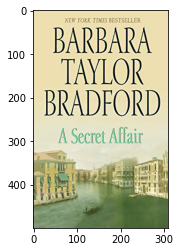

2: Lovers, with distance of 0.8510211136213515:


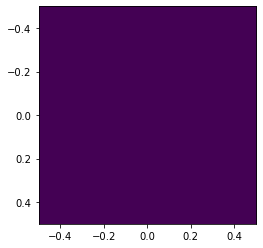

3: Dazzle, with distance of 0.8651799993614925:


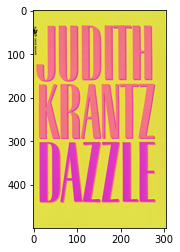

4: Colony, with distance of 0.8693410274972906:


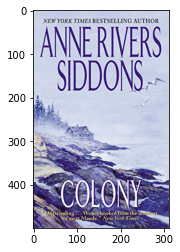

5: To Love Again, with distance of 0.8708355578959552:


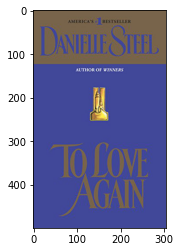

6: Special Delivery, with distance of 0.8775259328672098:


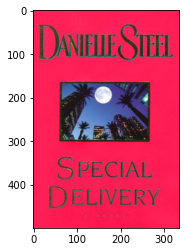

7: Secrecy, with distance of 0.8777345439562121:


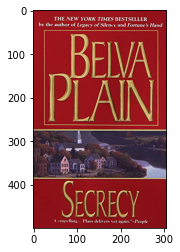

In [152]:
query_index = 143
distances, indices = model_knn.kneighbors(all_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 8)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(all_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, all_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
        for idx in df.index:
                if df['book_title'][idx]==all_user_rating_pivot.index[indices.flatten()[i]]:
                    path= df['img_l'][idx]
                    r = requests.get(path)
                    pil_im = Image.open(io.BytesIO(r.content))
                    im_array = np.asarray(pil_im)
                    plt.imshow(im_array)
                    plt.show()
                    break

Recommendations for Waiting to Exhale:

1: Alive : The Story of the Andes Survivors (Avon Nonfiction), with distance of 0.8955577594647971:


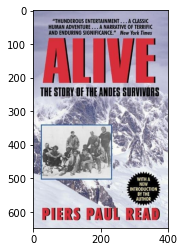

2: East of Eden, with distance of 0.8967844726309978:


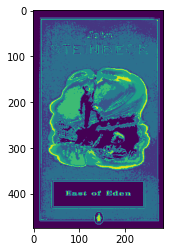

3: Moo, with distance of 0.9026386046014837:


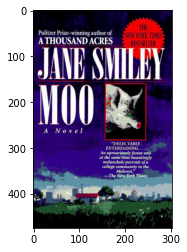

4: The SECRET DIARY OF ANNE BOLEYN, with distance of 0.9091107373126526:


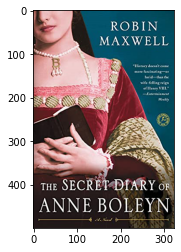

5: The Cat and the Curmudgeon, with distance of 0.9105179001103764:


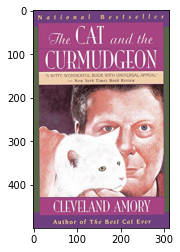

6: Black Hawk Down (Movie Tie-in), with distance of 0.9122855901935447:


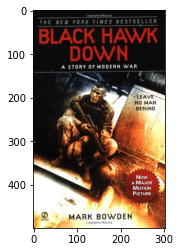

In [138]:
query_index = np.random.choice(all_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(all_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 7)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(all_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, all_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
        for idx in df.index:
                if df['book_title'][idx]==all_user_rating_pivot.index[indices.flatten()[i]]:
                    path= df['img_l'][idx]
                    r = requests.get(path)
                    pil_im = Image.open(io.BytesIO(r.content))
                    im_array = np.asarray(pil_im)
                    plt.imshow(im_array)
                    plt.show()
                    break

Recommendations for Bloodsucking Fiends: A Love Story:

1: Fluke : Or, I Know Why the Winged Whale Sings, with distance of 0.8016245486884978:


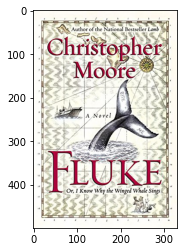

2: Rain, with distance of 0.8418269600274835:


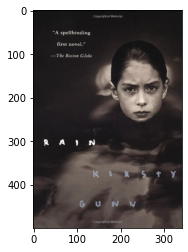

3: The Lust Lizard of Melancholy Cove, with distance of 0.8479287308553412:


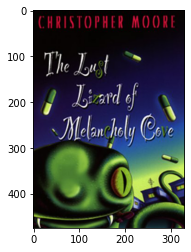

4: Living Dead in Dallas (Southern Vampire Mysteries), with distance of 0.8518576311414414:


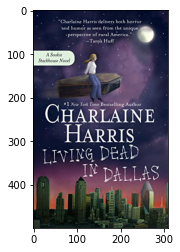

5: Crooked Little Heart, with distance of 0.8524124345088164:


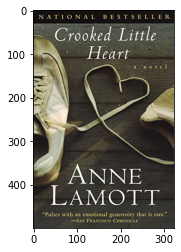

In [139]:
query_index = np.random.choice(all_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(all_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(all_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, all_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
        for idx in df.index:
                if df['book_title'][idx]==all_user_rating_pivot.index[indices.flatten()[i]]:
                    path= df['img_l'][idx]
                    r = requests.get(path)
                    pil_im = Image.open(io.BytesIO(r.content))
                    im_array = np.asarray(pil_im)
                    plt.imshow(im_array)
                    plt.show()
                    break